## Data Loading and Initial Processing

In this section, we load the diabetes dataset from the `sklearn` library. We then create data frames for features and the target variable, check for missing values, and understand the initial structure of the dataset.

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the diabetes dataset from sklearn
diabetes = load_diabetes()
# Check the keys in the dataset
diabetes.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [39]:
# Print the dataset description
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [40]:
# Create a DataFrame for the feature variables
df_feat = pd.DataFrame(data=diabetes['data'], columns=diabetes['feature_names'])

# Create a DataFrame for the target variable
df_target = pd.DataFrame(data=diabetes['target'], columns=['result'])

# Concatenate the feature and target DataFrames into one DataFrame
df = pd.concat([df_feat, df_target], axis=1)

In [41]:
# Display information about the DataFrame (data types, non-null counts, etc.)
df.info()

# Display basic statistical details
df.describe()

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  result  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
result    0
dtype: int64


## Visualizations

Here we perform initial visualizations to understand the relationships between features and identify potential outliers and multicollinearity. These visualizations include a correlation heatmap, box plots for each feature, and a pairplot (scatter plot matrix).

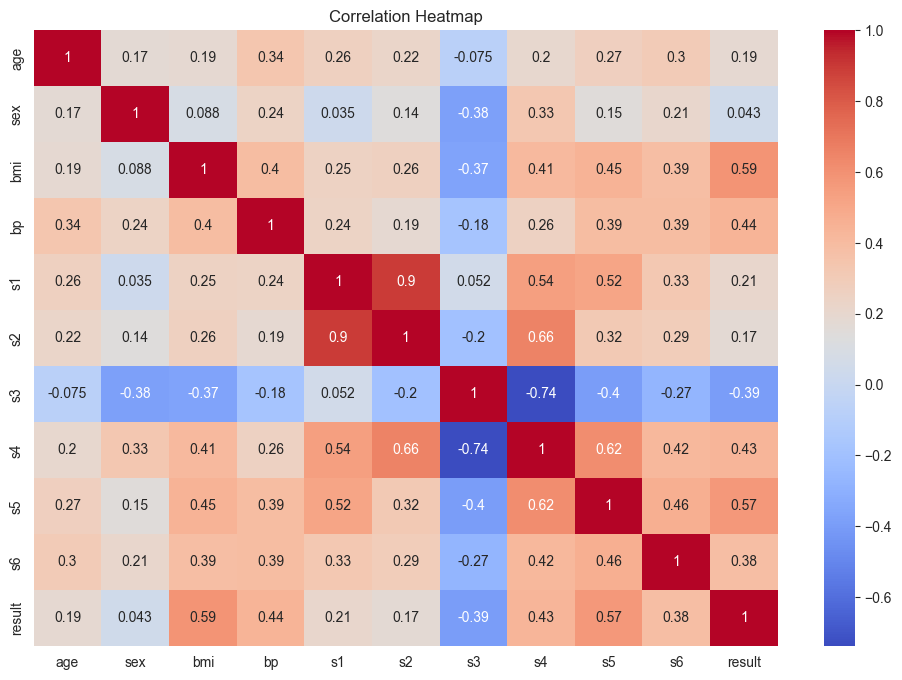

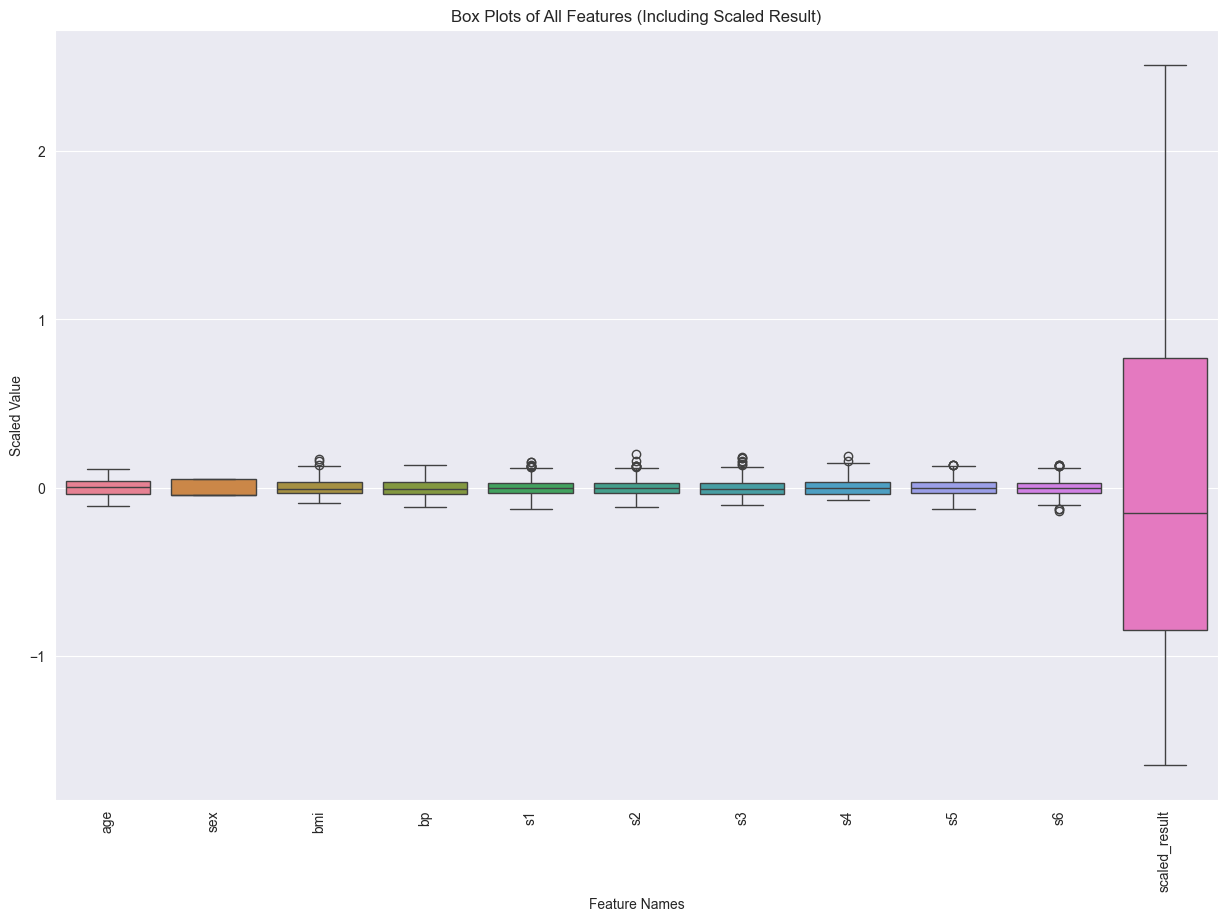

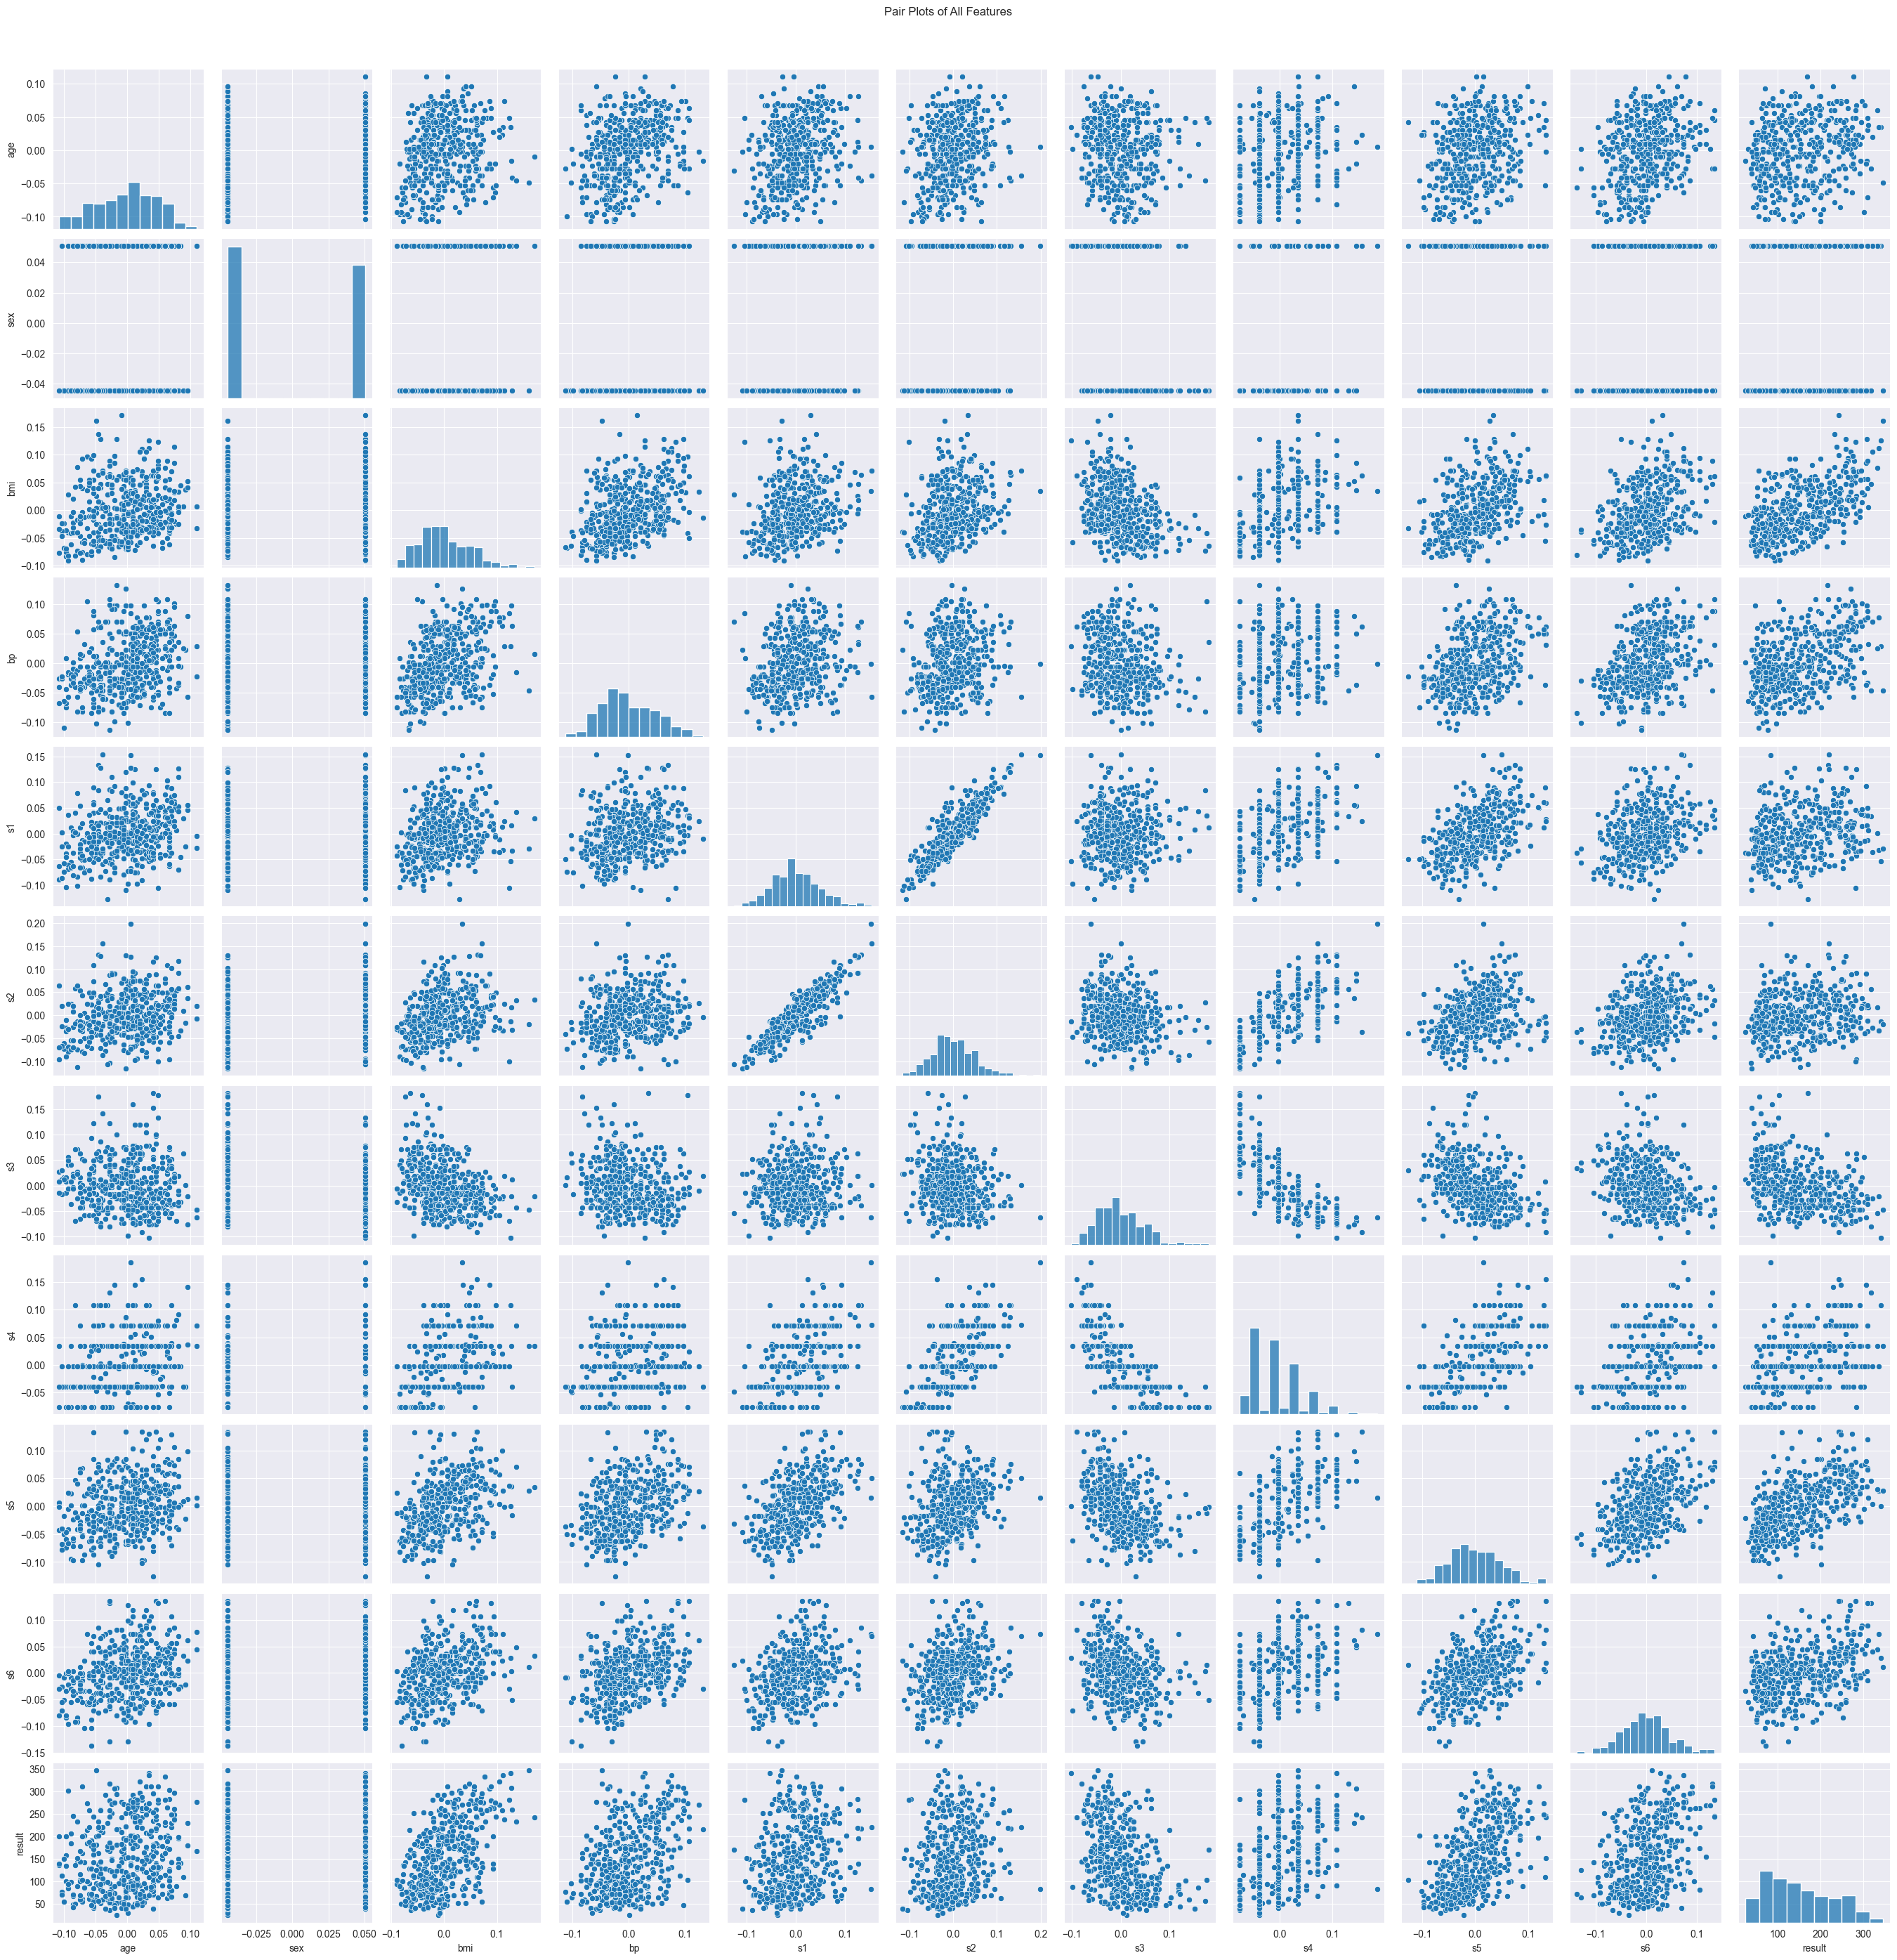

In [42]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Box Plots
# Standardize the 'result' column separately
scaled_result = (df['result'] - df['result'].mean()) / df['result'].std()
# Create a new DataFrame with the already scaled features and the separately scaled 'result'
scaled_df = df.drop(columns=['result']).copy()
scaled_df['scaled_result'] = scaled_result
# Plot the box plots for all features and the scaled 'result'
plt.figure(figsize=(15, 10))
sns.boxplot(data=scaled_df)
plt.title('Box Plots of All Features (Including Scaled Result)')
plt.xlabel('Feature Names')
plt.ylabel('Scaled Value')
plt.xticks(rotation=90)
plt.show()


# Scatter Plot Matrix (Pairplot)
pairplot = sns.pairplot(df)
pairplot.fig.suptitle('Pair Plots of All Features', y=1.02)  # y=1.02 adjusts the title position
plt.show()

## Outlier Identification and Handling

Outliers can skew the results of our analysis and model predictions. We identify outliers using the Interquartile Range (IQR) method and remove them from the dataset.

In [43]:
# Identify outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Outliers in each feature before imputation:\n", outliers)

# Imputing outliers
# Function to replace outliers with median
def impute_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median_value = df[column].median()
    df[column] = np.where(df[column] < lower_bound, median_value, df[column])
    df[column] = np.where(df[column] > upper_bound, median_value, df[column])

# Apply the function to all columns
for col in df.columns:
    impute_outliers_with_median(df, col)
    
# Check for outliers again after imputation
outliers_after_imputation = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Outliers in each feature after imputation:\n", outliers_after_imputation)

# Confirm data shape remains unchanged
print("Data shape after imputing outliers:", df.shape)

Outliers in each feature before imputation:
 age       0
sex       0
bmi       3
bp        0
s1        8
s2        7
s3        7
s4        2
s5        4
s6        9
result    0
dtype: int64
Outliers in each feature after imputation:
 age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
result    0
dtype: int64
Data shape after imputing outliers: (442, 11)


## Feature Selection Methods

Selecting the top features is crucial for building efficient and interpretable models. We use four different methods to select the top four features:
1. Correlation with the target variable.
2. Feature importance from Random Forest.
3. Recursive Feature Elimination (RFE).
4. Lasso Regression coefficients.

In [44]:
# Split data into features and target
X = df.drop('result', axis=1)
y = df['result']

# 1. Correlation with the Target Variable
correlation_with_target = df.corr()['result'].abs().sort_values(ascending=False)
top_features_corr = correlation_with_target.index[1:5]  # Skip the first as it's the target itself
print("Top 4 features based on correlation with target:", top_features_corr)

# 2. Feature Importance from Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_features_rf = feature_importance_df['feature'][:4].values
print("Top 4 features based on Random Forest importance:", top_features_rf)

# 3. Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=4)
rfe = rfe.fit(X, y)
top_features_rfe = X.columns[rfe.support_]
print("Top 4 features selected by RFE:", top_features_rfe)

# 4. Lasso Regression Coefficients
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
coefficients = pd.Series(lasso.coef_, index=X.columns).abs().sort_values(ascending=False)
top_features_lasso = coefficients.index[:4]
print("Top 4 features based on Lasso coefficients:", top_features_lasso)   

Top 4 features based on correlation with target: Index(['s5', 'bmi', 's4', 'bp'], dtype='object')
Top 4 features based on Random Forest importance: ['s5' 'bmi' 'bp' 'age']
Top 4 features selected by RFE: Index(['bmi', 'bp', 's1', 's5'], dtype='object')
Top 4 features based on Lasso coefficients: Index(['s5', 'bmi', 's1', 'bp'], dtype='object')


## Modeling with Selected Features

The features that are commonly selected across the different methods are:
s5 (selected by all methods)
bmi (selected by all methods)
bp (selected by three methods)
s1 (selected by two methods)
These features can be considered as the most important ones, given that multiple feature selection methods have identified them. Using the selected features, we build and evaluate different regression models, including Linear Regression, Lasso, Ridge, SVR, and Random Forest. We use evaluation metrics like MAE, MSE, RMSE, and R² to compare the performance of these models.

In [45]:
# Define selected features based on previous selection criteria
selected_features = ['bmi', 'bp', 's1', 's5']
X_selected = df[selected_features]


def cross_validate_model(model, X, y):
    # Define the scoring metrics for cross-validation
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

    # Perform cross-validation for MAE
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    mae_scores = -scores  # Convert negative scores to positive
    mae_mean = mae_scores.mean()  # Calculate mean MAE

    # Perform cross-validation for MSE
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert negative scores to positive
    rmse_scores = np.sqrt(mse_scores)  # Calculate RMSE from MSE
    mse_mean = mse_scores.mean()  # Calculate mean MSE
    rmse_mean = rmse_scores.mean()  # Calculate mean RMSE

    # Perform cross-validation for R²
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    r2_scores = scores  # R² scores are already positive
    r2_mean = r2_scores.mean()  # Calculate mean R²

    return mae_mean, mse_mean, rmse_mean, r2_mean
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.01),
    'Ridge Regression': Ridge(alpha=1),
    'SVR': SVR(C=1.0, epsilon=0.2),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Iterate over each model to evaluate its performance using cross-validation
for name, model in models.items():
    mae, mse, rmse, r2 = cross_validate_model(model, X_selected, y)
    print(f'{name} CV: MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}')


Linear Regression CV: MAE=45.30, MSE=3107.18, RMSE=55.71, R²=0.46
Lasso Regression CV: MAE=45.33, MSE=3107.74, RMSE=55.71, R²=0.46
Ridge Regression CV: MAE=51.19, MSE=3695.18, RMSE=60.73, R²=0.36
SVR CV: MAE=57.14, MSE=4633.86, RMSE=67.94, R²=0.21
Random Forest CV: MAE=48.93, MSE=3699.36, RMSE=60.71, R²=0.36


From the given performance metrics, it appears that Linear Regression has the best overall performance in terms of Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.Given these results, we will select the Linear Regression model for deployment. Below are the steps for finalizing, saving, and deploying the model.

In [51]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Initialize the Linear Regression model
final_linear = LinearRegression()

# Train the model on the entire dataset
final_linear.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_linear.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred)

print(f'Final Linear Regression: MAE={final_mae}, MSE={final_mse}, RMSE={final_rmse}, R²={final_r2}')

Final Linear Regression: MAE=41.89365039909032, MSE=2730.036536954704, RMSE=52.249751549215084, R²=0.4942791968568765


In [52]:
import joblib
# Save the model to a file
joblib_file = "linear_model.pkl"  
print(f"Model saved to {joblib_file}")

Model saved to linear_model.pkl


In [53]:
import numpy as np
import pandas as pd
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the trained model
model = joblib.load("linear_model.pkl")

# Define the input feature names and their user-friendly prompts
feature_prompts = {
    'bmi': "Body Mass Index (BMI)",
    'bp': "Average Blood Pressure (BP)",
    's1': "Total Serum Cholesterol (TC)",
    's5': "Log of Serum Triglycerides Level (LTG)"
}

# Create input widgets for each feature using BoundedFloatText widgets
input_widgets = {
    key: widgets.BoundedFloatText(
        value=0.0,
        min=-100000.0,
        max=100000.0,
        step=0.01,
        layout=widgets.Layout(width='200px')
    )
    for key in feature_prompts.keys()
}

# Create labels for each feature
labels = {
    key: widgets.Label(value=description, layout=widgets.Layout(width='300px'))
    for key, description in feature_prompts.items()
}

# Combine labels and input widgets in horizontal boxes
hboxes = [
    widgets.HBox([labels[key], input_widgets[key]], layout=widgets.Layout(margin='5px 0'))
    for key in feature_prompts.keys()
]

# Create a button widget for prediction
predict_button = widgets.Button(description="Predict")

# Create a button widget for resetting the inputs
reset_button = widgets.Button(description="Reset")

# Create an output widget to display the result
output = widgets.Output()

# Define the prediction function
def predict(button):
    try:
        # Collect user inputs from the widgets
        features = []
        for key, widget in input_widgets.items():
            value = widget.value
            features.append(float(value))  # Convert the value to float
        
        # Convert the list to a pandas DataFrame
        features_df = pd.DataFrame([features], columns=feature_prompts.keys())
        
        # Make prediction
        prediction = model.predict(features_df)
        
        # Format the result to two decimal places
        formatted_prediction = f"{prediction[0]:.2f}"
        
        # Output the result
        with output:
            clear_output()
            print(f"The predicted value is: {formatted_prediction}")
    except ValueError:
        with output:
            clear_output()
            print("Please enter valid numerical values.")

# Define the reset function
def reset(button):
    for widget in input_widgets.values():
        widget.value = 0.0  # Reset to a default value, you can set this to None or any default value

    with output:
        clear_output()
        print("Inputs have been reset.")

# Attach the functions to the button click events
predict_button.on_click(predict)
reset_button.on_click(reset)

# Create a horizontal box for buttons and center them
buttons_hbox = widgets.HBox([predict_button, reset_button], layout=widgets.Layout(justify_content='center', width='100%'))

# Display the widgets in a vertical box layout
vbox = widgets.VBox(hboxes + [buttons_hbox, output])
display(vbox)
